<a href="https://colab.research.google.com/github/LeszekBlazewski/WWZD/blob/master/big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic phrases data visualisation for given dataset

## System setup & GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install scikit-learn==1.0.1
!pip install pytorch-pretrained-bert==0.6.2
!pip install numba==0.51.2
!pip install umap-learn==0.5.2
!pip install torch==1.10.0
!pip install tqdm
!pip install ujson

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import torch
from pytorch_pretrained_bert.modeling import BertPreTrainedModel, BertModel
from pytorch_pretrained_bert.tokenization import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook
import pickle
import os
import json
import ujson
import tarfile
import copy
import shutil

# Instructions for input variables 

**NUMBER_OF_SAMPLES** -> How many samples do we want to analyse, None for whole dataset

**USE_CPU** -> Whether the calculations are performed on CPU

**USE_CACHE** -> Whether you have previous runs stored and want to read from that files storen on GDrive

**CREATE_ARCHIVE** -> Whether final archive for docker container should be created

**PRINT_CHARTS** -> Should the charts be displayed in collab

**RUN_FILE_BENCHMARKS** -> Whether benchmarks for data and model files should be benchmarked (load and size benchmark)

**GDRIVE_PATH** -> Root path of folder on your drive where all models/datasets and objects are/will be saved. Inside this directory you need to create the following directory structure (or update the notebook accordingly):

```
/content/drive/MyDrive/Colab/WWZD
├── data
│   ├── jigsaw-toxic
│   │   └── dataset.csv
│   └── polytical-tweets
│       └── dataset.csv
└── model
    ├── bert.tar.gz
    ├── bert_config.json
    ├── pytorch_model.bin
    └── vocab.txt
```

**The pretrained BERT model (contents of model directory) can be download from**: 

https://drive.google.com/drive/folders/1bWfy17d0fpXpCumRckzTk43_38xOePtg?usp=sharing or https://max-cdn.cdn.appdomain.cloud/max-toxic-comment-classifier/1.0.0/assets.tar.gz or extracted from quay.io/codait/max-toxic-comment-classifier docker image

**The training dataset displayed in this notebook can be found here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data**

**DATASET_NAME** -> Name of the folder of dataset which should be visualised

**DATASET_TEXT_COLUMN_NAME** -> Name of the column in dataset which contains the text samples

## Initialization


In [3]:
LABEL_LIST = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
NUMBER_OF_SAMPLES = None # set to None for all

USE_CPU = False
USE_CACHE = False
CREATE_ARCHIVE = False # whether to create the tar archive for datasets
PRINT_CHARTS = True
RUN_FILE_BENCHMARKS = True

GDRIVE_PATH = '/content/drive/MyDrive/Colab/WWZD'
MODEL_CONFIG_PATH = f"{GDRIVE_PATH}/model"

DATASET_NAME = "jigsaw-toxic"
DATASET_TEXT_COLUMN_NAME = "comment_text" # Name of the column in CSV which has the text to classify
DATASET_PATH = f"{GDRIVE_PATH}/data/{DATASET_NAME}/dataset.csv"
IS_TRAINING_DATASET = True if DATASET_NAME == "jigsaw-toxic" else False

SAVED_OBJECTS_ROOT_PATH = f"{GDRIVE_PATH}/saved-objects/{NUMBER_OF_SAMPLES}-samples" if NUMBER_OF_SAMPLES else f"{GDRIVE_PATH}/saved-objects/all-samples"
SAVED_OBJECTS_PATH = f"{SAVED_OBJECTS_ROOT_PATH}/{DATASET_NAME}"

if not os.path.exists(SAVED_OBJECTS_PATH):
    os.makedirs(SAVED_OBJECTS_PATH)

## Input and features helpers

In [4]:
class InputExample(object):
    """A single test example for simple sequence classification."""

    def __init__(self, guid, text_a):
        self.guid = guid
        self.text_a = text_a

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids

def convert_examples_to_features(examples, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    for (ex_index, example) in enumerate(tqdm_notebook(examples, desc="Tokenizer progress")):
        tokens_a = tokenizer.tokenize(str(example.text_a))

        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        features.append(
            InputFeatures(input_ids=input_ids,
                            input_mask=input_mask,
                            segment_ids=segment_ids
                        ))
    return features

## Full pretrained model with prediction


In [5]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return (pooled_output,logits)

## Model wrapper to perform data processing and calculations

In [6]:
class BertModelWrapper:
    def __init__(self, tokenizer_instance, pretrained_model_instance):
        # 1. set the appropriate parameters
        self.eval_batch_size = 64
        self.max_seq_length = 256
        
        # 2. Initialize the PyTorch model based on passed model and tokenizer instance
        self.tokenizer = tokenizer_instance
        self.model = pretrained_model_instance

        if USE_CPU:
            self.device = torch.device("cpu")
            self.model.to(self.device)
        else:
            self.model.cuda()

        # 3. Set the layers to evaluation mode
        self.model.eval()

    def pre_process(self, input):
        # Converting the input to features
        test_examples = [InputExample(guid=i, text_a=x) for i, x in enumerate(input)]
        test_features = convert_examples_to_features(test_examples, self.max_seq_length, self.tokenizer)

        all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)

        # Turn input examples into batches
        test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
        test_sampler = SequentialSampler(test_data)
        self.test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=self.eval_batch_size)

        return test_examples

    def post_process(self, result):
        """Convert the prediction output to the expected output."""
        # Generate the output format for every input string
        output = [{LABEL_LIST[0]: p[0],
                   LABEL_LIST[1]: p[1],
                   LABEL_LIST[2]: p[2],
                   LABEL_LIST[3]: p[3],
                   LABEL_LIST[4]: p[4],
                   LABEL_LIST[5]: p[5],
                   } for p in result]

        return output

    def predict(self, input):
        """Predict the class probabilities using the BERT model."""
        self.pre_process(input)
        all_logits = None
        all_pooled_outputs = None

        for step, batch in enumerate(tqdm_notebook(self.test_dataloader,desc="Predictions progress")):
            input_ids, input_mask, segment_ids = batch

            if USE_CPU:
                input_ids = input_ids.to(self.device)
                input_mask = input_mask.to(self.device)
                segment_ids = segment_ids.to(self.device)
            else:
                input_ids = input_ids.cuda()
                input_mask = input_mask.cuda()
                segment_ids = segment_ids.cuda()

            # Compute the logits
            with torch.no_grad():
                pooled_output, logits = self.model(input_ids, segment_ids, input_mask)
                logits = logits.sigmoid()

            # Save the logits
            if all_logits is None:
                all_logits = logits.detach().cpu().numpy()
                all_pooled_outputs = pooled_output.detach().cpu().numpy()
            else:
                all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
                all_pooled_outputs = np.concatenate((all_pooled_outputs, pooled_output.detach().cpu().numpy()), axis=0)

        # Return the last layer outputs and predictions
        encoded_predictions = self.post_process(all_logits)
        return (all_pooled_outputs, encoded_predictions)

## Loading dataset


In [7]:
dataset_df = pd.read_csv(DATASET_PATH)

# reduce to given number of samples
if NUMBER_OF_SAMPLES:
    dataset_df = dataset_df.head(NUMBER_OF_SAMPLES)

# remove all columns except text to classify
if not IS_TRAINING_DATASET:
    dataset_df = dataset_df.filter([DATASET_TEXT_COLUMN_NAME])
else:
    dataset_df = dataset_df.drop('id', 1)

# change name of samples column to 'text' (used in api to serialize correct dictionary field)
dataset_df = dataset_df.rename(columns={DATASET_TEXT_COLUMN_NAME: 'text'})

# Convert samples to a python list in order to feed it to the model
test_samples = dataset_df["text"].values.tolist()

## Usage of created wrapper model

In [8]:
# Load pretrained model with tokenizer

tokenizer_instance = BertTokenizer.from_pretrained(MODEL_CONFIG_PATH, do_lower_case=True)

if USE_CPU:
    model_state_dict = torch.load(f"{MODEL_CONFIG_PATH}/pytorch_model.bin", map_location='cpu')
else:
    model_state_dict = torch.load(f"{MODEL_CONFIG_PATH}/pytorch_model.bin")

pretrained_model_instance = BertForMultiLabelSequenceClassification.from_pretrained(MODEL_CONFIG_PATH, num_labels=len(LABEL_LIST), state_dict=model_state_dict)

model = BertModelWrapper(tokenizer_instance, pretrained_model_instance)

if USE_CACHE and os.path.exists(SAVED_OBJECTS_PATH):
    with open(f'{SAVED_OBJECTS_PATH}/pooled_outputs.pkl', 'rb') as in_file:
        pooled_outputs = pickle.load(in_file)
    with open(f'{SAVED_OBJECTS_PATH}/classification_results.pkl', 'rb') as in_file:
        classification_results = pickle.load(in_file)
else:
    pooled_outputs, classification_results = model.predict(test_samples)
    #save outputs to file
    with open(f'{SAVED_OBJECTS_PATH}/pooled_outputs.pkl', 'wb') as outp:
        pickle.dump(pooled_outputs, outp, pickle.HIGHEST_PROTOCOL)

    with open(f'{SAVED_OBJECTS_PATH}/classification_results.pkl', 'wb') as outp:
        pickle.dump(classification_results, outp, pickle.HIGHEST_PROTOCOL)

## Process classification results (extend dataset with results of classification)

In [9]:
# convert predictions to 0/1 values 
classification_results_rounded = copy.deepcopy(classification_results)
for text in classification_results_rounded:
    text['toxic'] = round(text['toxic'])
    text['severe_toxic'] = round(text['severe_toxic'])
    text['obscene'] = round(text['obscene'])
    text['threat'] = round(text['threat'])
    text['insult'] = round(text['insult'])
    text['identity_hate'] = round(text['identity_hate'])

classification_results_rounded_df = pd.DataFrame.from_dict(classification_results_rounded)

#Do it only for non training datasets, since the training one has the class labels already applied
if not IS_TRAINING_DATASET:
    dataset_df = pd.concat([dataset_df, classification_results_rounded_df], axis=1)

## Load PCA && UMAP

In [10]:
%%time

if USE_CACHE and os.path.exists(SAVED_OBJECTS_PATH):
    with open(f'{SAVED_OBJECTS_PATH}/pca.model.pkl', 'rb') as in_file:
        pca_model = pickle.load(in_file)
    with open(f'{SAVED_OBJECTS_PATH}/umap.model.pkl', 'rb') as in_file:
        umap_model = pickle.load(in_file)
    with open(f'{SAVED_OBJECTS_PATH}/pca-result.pkl', 'rb') as in_file:
        pca_result = pickle.load(in_file)
    with open(f'{SAVED_OBJECTS_PATH}/umap-result.pkl', 'rb') as in_file:
        umap_result = pickle.load(in_file)
else:
    pca_components=2
    umap_components=2

    pca_model = PCA(n_components=pca_components)
    umap_model = umap.UMAP(n_components=umap_components)

    pca_result = pca_model.fit_transform(pooled_outputs)
    umap_result = umap_model.fit_transform(pooled_outputs)

    # save models and outputs to file
    with open(f'{SAVED_OBJECTS_PATH}/pca.model.pkl', 'wb') as outp:
        pickle.dump(pca_model, outp, pickle.HIGHEST_PROTOCOL)
    with open(f'{SAVED_OBJECTS_PATH}/umap.model.pkl', 'wb') as outp:
        pickle.dump(umap_model, outp, pickle.HIGHEST_PROTOCOL)
    with open(f'{SAVED_OBJECTS_PATH}/pca-result.pkl', 'wb') as outp:
        pickle.dump(pca_result, outp, pickle.HIGHEST_PROTOCOL)
    with open(f'{SAVED_OBJECTS_PATH}/umap-result.pkl', 'wb') as outp:
        pickle.dump(umap_result, outp, pickle.HIGHEST_PROTOCOL)

# Convert to pandas df with class labels assigned
pca_result_df = pd.DataFrame(data=pca_result, columns = ['DIM1', 'DIM2'])
pca_result_df = pd.concat([pca_result_df, dataset_df.iloc[:,-6:]], axis=1)
umap_result_df = pd.DataFrame(data=umap_result, columns = ['DIM1', 'DIM2'])
umap_result_df = pd.concat([umap_result_df, dataset_df.iloc[:,-6:]], axis=1)

CPU times: user 6.67 s, sys: 3.16 s, total: 9.83 s
Wall time: 35.1 s


## Plot good vs toxic phrases

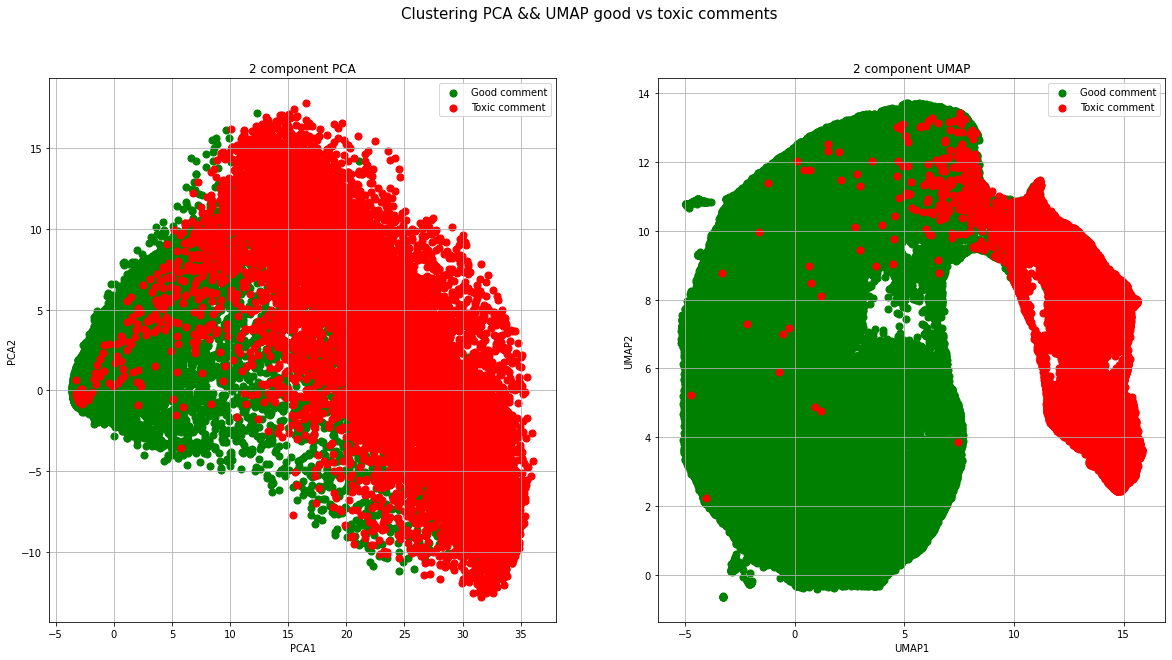

In [11]:
# plotting only 2 color chart, good vs 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate' comments

if PRINT_CHARTS:
    small_font_size = 12
    fig, axes = plt.subplots(1, 2)
    fig.suptitle('Clustering PCA && UMAP good vs toxic comments', fontsize = 15)
    fig.set_size_inches((20,10))

    clustering_results = { "PCA" : pca_result_df,
                        "UMAP" : umap_result_df
                        }

    # Take the assigned class labels directly from dataset
    for idx, (algo,result_df) in enumerate(clustering_results.items()):
        axes[idx].set_xlabel(f"{algo}1")
        axes[idx].set_ylabel(f"{algo}2")
        axes[idx].set_title(f'2 component {algo}', fontsize=small_font_size)
        # get only good samples (not a single 1 in any of the class fields)
        good_samples = result_df[result_df.iloc[:, -6] != 1]
        bad_samples = pd.concat([result_df, good_samples]).drop_duplicates(keep=False)
        axes[idx].scatter(good_samples['DIM1']
                        ,good_samples['DIM2']
                        ,c = "green"
                        ,s = 50)
        axes[idx].scatter(bad_samples['DIM1']
                        ,bad_samples['DIM2']
                        ,c = "red"
                        ,s = 50)
        axes[idx].legend(["Good comment", "Toxic comment"] )
        axes[idx].grid()

    # save to file
    fig.savefig(f"{SAVED_OBJECTS_PATH}/pca-umap-good-vs-toxic.png")

## PCA && UMAP (for 6 classes)
Because we use multi label classification, the output of pre-trained BERT model consists of 6 probablilities corresponding to one of the following classes: **'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'**.

Therefore as a result of prediction of given point we acquire 6 values which state how much given text sample corresponds to given class. This makes class clolored plotting hard because some samples can belong to multiple classes (this actually happens quite a lot in the training dataset).

Because matplotlib is not suited for dynamic data display, here only subset of the coloring will be present without dynamic updates to check whether comments falling into same toxicity group are clustered together.

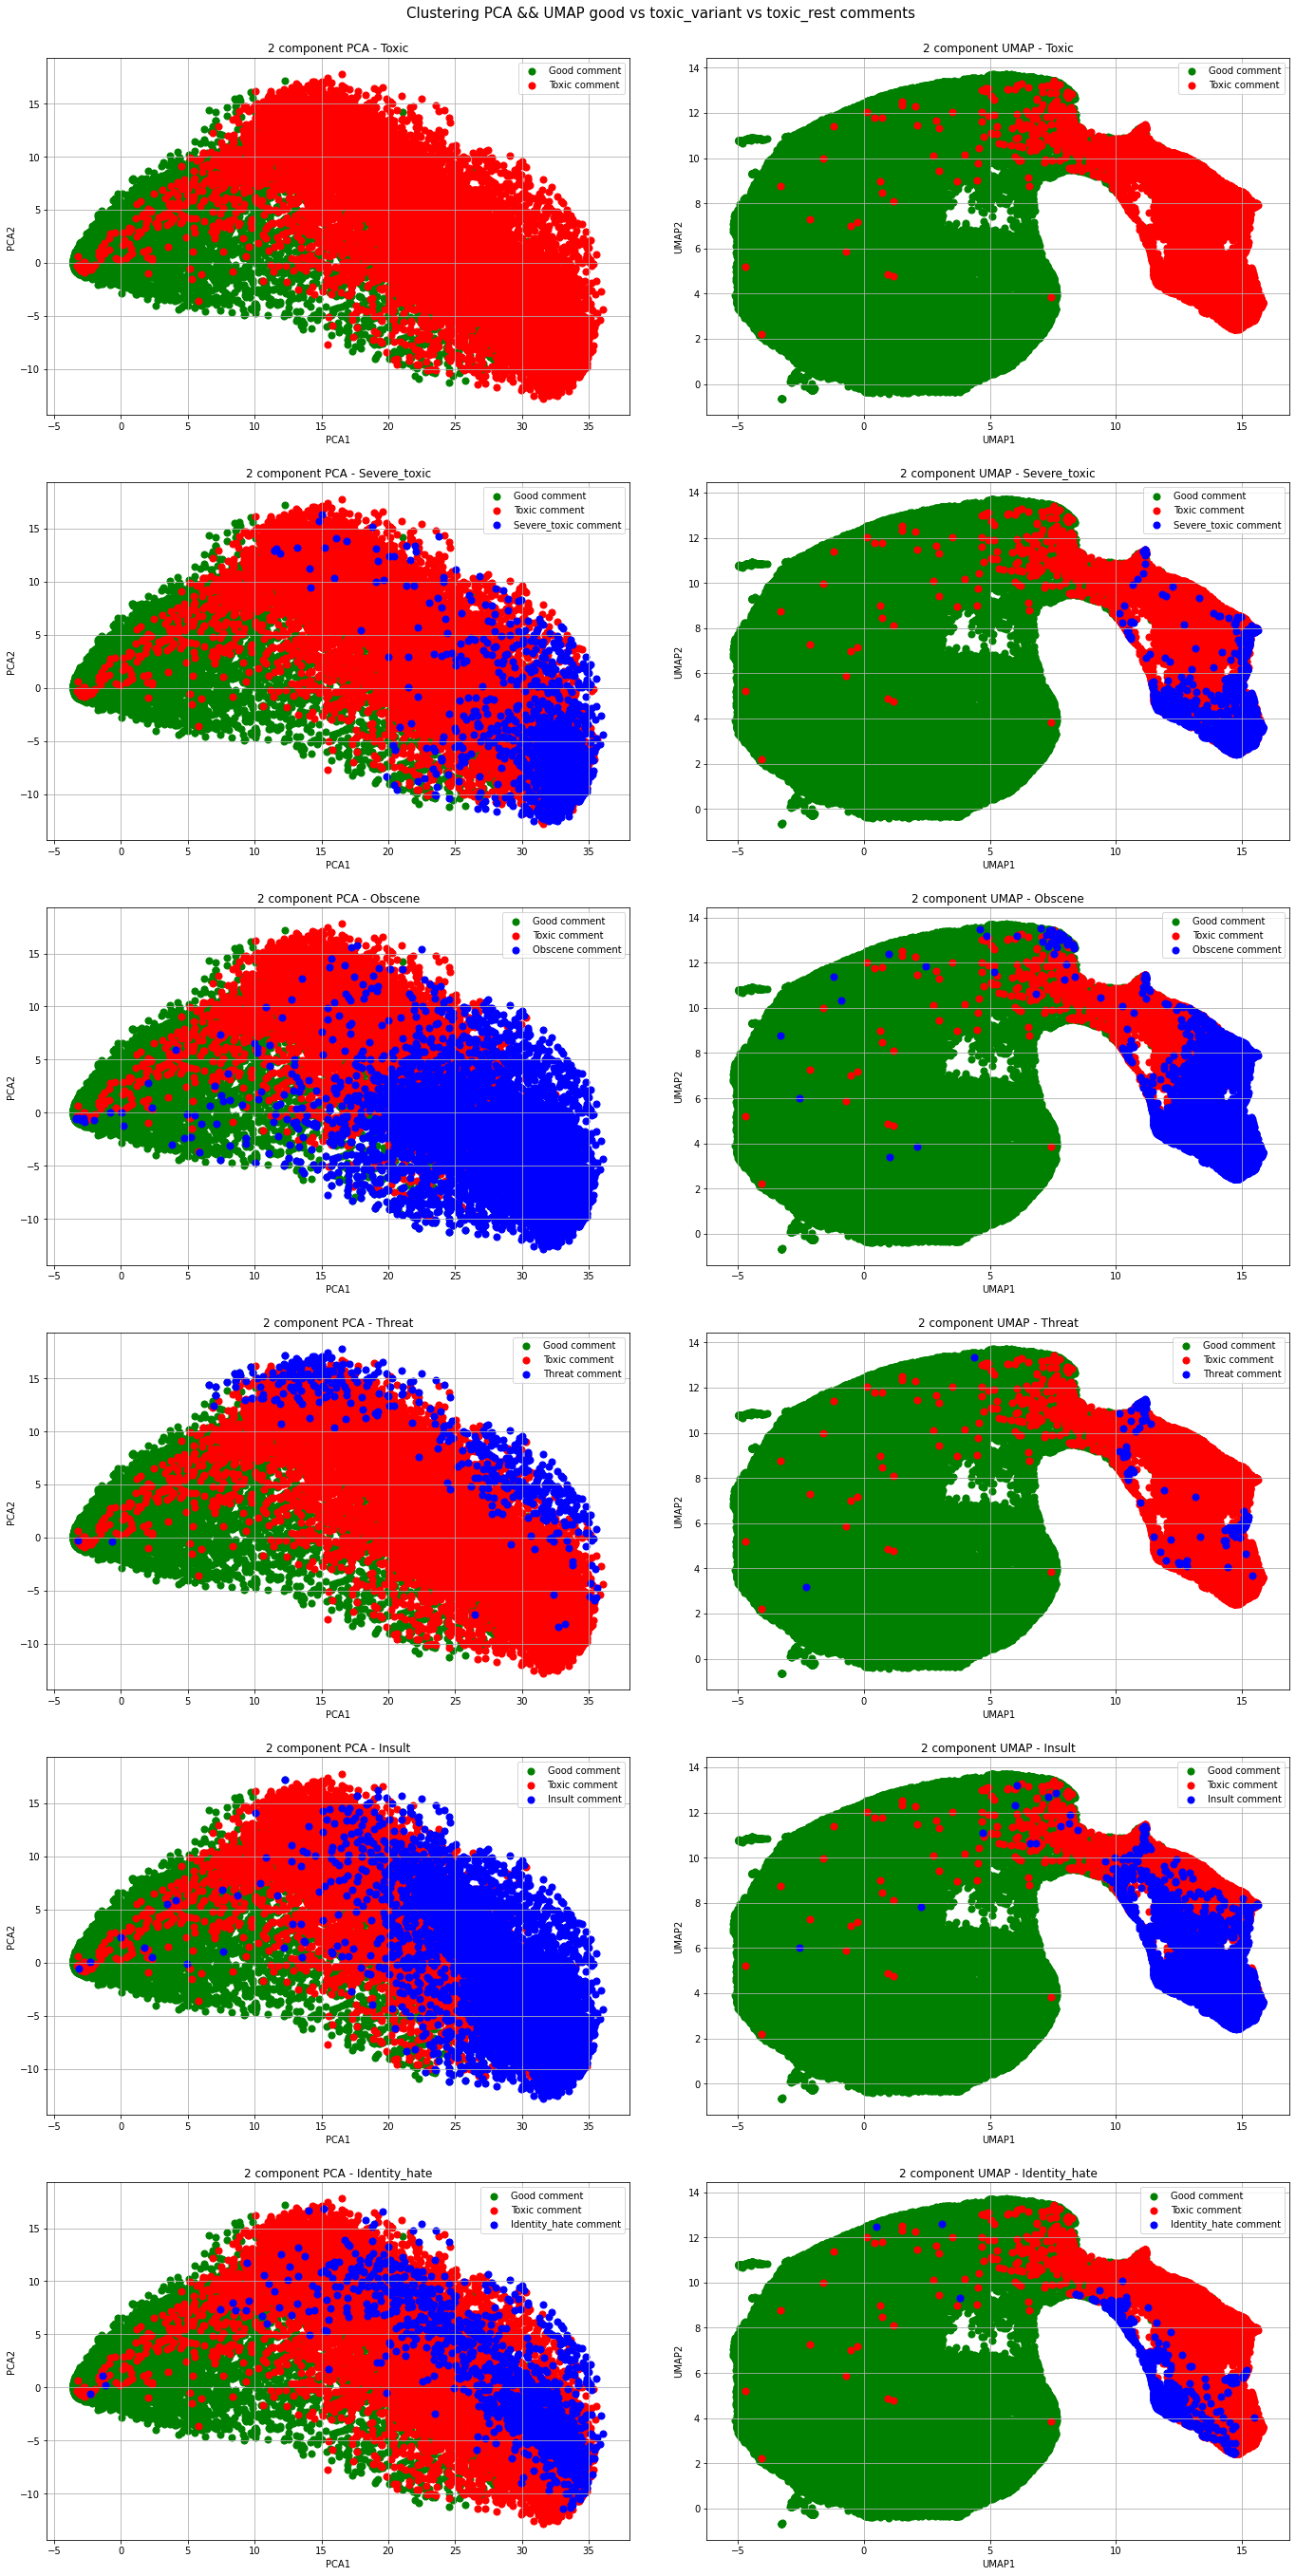

In [12]:
# Print 12 charts, with 3 groups (colors): good, given toxic variance for example insult, toxic rest
# On left PCA on right UMAP
# each row will have a different one toxic_variant variable colored and rest will be split accross good ones and toxic ones

if PRINT_CHARTS:
    fig_2, axes = plt.subplots(nrows=6, ncols=2)
    fig_2.suptitle('Clustering PCA && UMAP good vs toxic_variant vs toxic_rest comments', fontsize = 15)
    fig_2.set_size_inches((20,40))
    plt.tight_layout(pad=5, rect=[0, 0.03, 1, 0.98])

    for i in range(6):
        for idx, (algo,result_df) in enumerate(clustering_results.items()):
            axes[i][idx].set_xlabel(f"{algo}1")
            axes[i][idx].set_ylabel(f"{algo}2")
            class_name = LABEL_LIST[i]
            axes[i][idx].set_title(f'2 component {algo} - {class_name.capitalize()}', fontsize=small_font_size)
            good_samples = result_df[result_df.iloc[:, -6] != 1]
            toxic_variant_samples = result_df.query(f"{class_name} == 1")
            rest_toxic_samples = pd.concat([result_df, good_samples, toxic_variant_samples]).drop_duplicates(keep=False)
            axes[i][idx].scatter(good_samples['DIM1']
                                ,good_samples['DIM2']
                                ,c = "green"
                                ,s = 50)
            if not i == 0:
                axes[i][idx].scatter(rest_toxic_samples['DIM1']
                                    ,rest_toxic_samples['DIM2']
                                    ,c = "red"
                                    ,s = 50)
            axes[i][idx].scatter(toxic_variant_samples['DIM1']
                                ,toxic_variant_samples['DIM2']
                                ,c = "blue" if i != 0 else "red"
                                ,s = 50)
            if i == 0:
                axes[i][idx].legend(["Good comment", "Toxic comment"])
            else:
                axes[i][idx].legend(["Good comment","Toxic comment", f"{class_name.capitalize()} comment",])
            axes[i][idx].grid()

    # save to file
    fig_2.savefig(f"{SAVED_OBJECTS_PATH}/pca-umap-good-vs-given-class.png")

## Adding new sample to the chart (obscene comment)


Tokenizer progress:   0%|          | 0/1 [00:00<?, ?it/s]

Predictions progress:   0%|          | 0/1 [00:00<?, ?it/s]

classified sentence: You are a stupid fuck!
predictions: {'toxic': 0.9956468, 'severe_toxic': 0.30195338, 'obscene': 0.9878106, 'threat': 0.0037220553, 'insult': 0.9845428, 'identity_hate': 0.022330552}


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


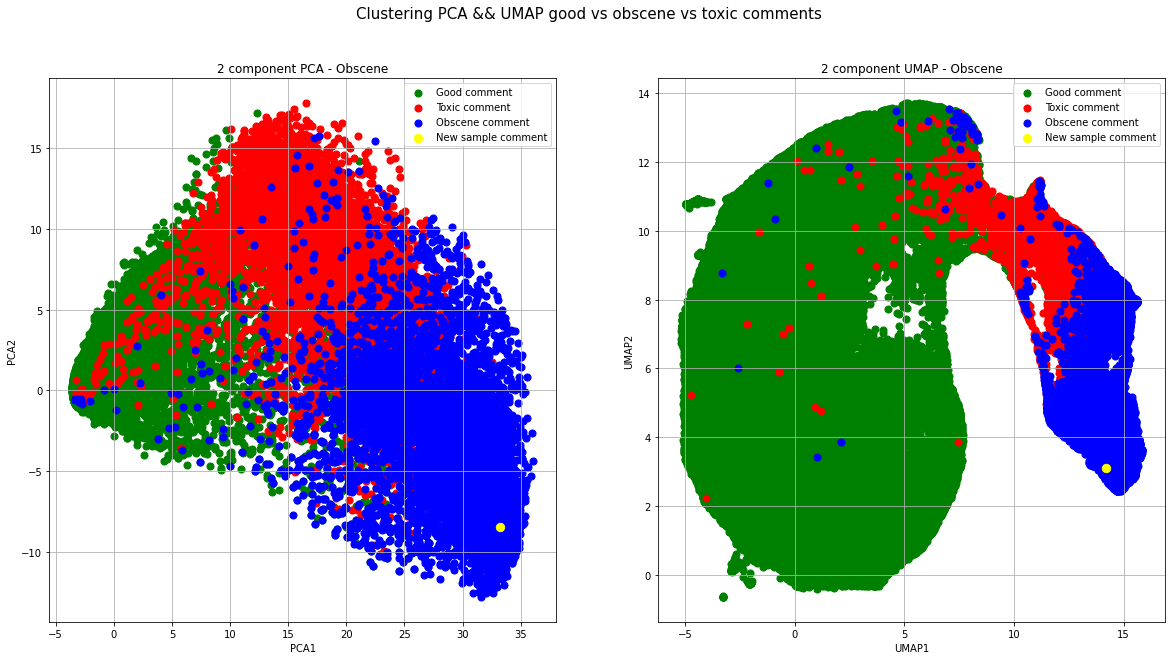

In [13]:
if PRINT_CHARTS:
    new_sample = "You are a stupid fuck!"

    pooled_outputs_for_sample, new_classification_result = model.predict([new_sample])

    pred_for_sample = new_classification_result[0]

    print(f"classified sentence: {new_sample}\npredictions: {pred_for_sample}")

    # convert predictions to 0/1
    for (class_name,pred_value) in pred_for_sample.items():
        pred_for_sample[class_name] = round(pred_value)

    # get dimension reduction output
    pca_result_for_sample = pca_model.transform(pooled_outputs_for_sample)
    umap_result_for_sample= umap_model.transform(pooled_outputs_for_sample)

    # Add dimension reduction to sample
    pca_pred_copy = copy.deepcopy(pred_for_sample)
    umap_pred_copy = copy.deepcopy(pred_for_sample)
    pca_pred_copy["DIM1"] = pca_result_for_sample[0][0]
    pca_pred_copy["DIM2"] = pca_result_for_sample[0][1]
    umap_pred_copy["DIM1"] = umap_result_for_sample[0][0]
    umap_pred_copy["DIM2"] = umap_result_for_sample[0][1]

    # create final df
    pca_result_extended_df = pca_result_df.copy().append(pca_pred_copy, ignore_index=True)
    umap_result_extended_df = umap_result_df.copy().append(umap_pred_copy, ignore_index=True)

    fig, axes = plt.subplots(1, 2)
    fig.suptitle('Clustering PCA && UMAP good vs obscene vs toxic comments', fontsize = 15)
    fig.set_size_inches((20,10))

    clustering_results_df = { "PCA" : pca_result_extended_df,
                            "UMAP" : umap_result_extended_df
                            }

    for idx, (algo,result_df) in enumerate(clustering_results_df.items()):
        axes[idx].set_xlabel(f"{algo}1")
        axes[idx].set_ylabel(f"{algo}2")
        axes[idx].set_title(f'2 component {algo} - Obscene', fontsize=small_font_size)
        good_samples = result_df[result_df.iloc[:, -6] != 1]
        toxic_variant_samples = result_df.query(f"obscene == 1")
        rest_toxic_samples = pd.concat([result_df, good_samples, toxic_variant_samples]).drop_duplicates(keep=False)
        axes[idx].scatter(good_samples['DIM1']
                            ,good_samples['DIM2']
                            ,c = "green"
                            ,s = 50)
        axes[idx].scatter(rest_toxic_samples['DIM1']
                            ,rest_toxic_samples['DIM2']
                            ,c = "red"
                            ,s = 50)
        axes[idx].scatter(toxic_variant_samples['DIM1']
                            ,toxic_variant_samples['DIM2']
                            ,c = "blue"
                            ,s = 50)
        axes[idx].scatter(result_df.iloc[-1]['DIM1']
                            ,result_df.iloc[-1]['DIM2']
                            ,c = "yellow"
                            ,s = 70)
        axes[idx].legend(["Good comment","Toxic comment", "Obscene comment", "New sample comment"])
        axes[idx].grid()

    fig.savefig(f"{SAVED_OBJECTS_PATH}/pca-umap-new-sample")

## Check how converting predictions to bool affects the correctness of assigned labels (only for training jigsaw-toxic dataset)


In [14]:
if IS_TRAINING_DATASET:
    only_class_labels_df = dataset_df.drop(["text"], axis=1)
    difference_df = only_class_labels_df.compare(classification_results_rounded_df)

    print(f"Error rate: {round(difference_df.shape[0] / dataset_df.shape[0] * 100,2)}% (there are errors inside dataset)")

Error rate: 3.18% (there are errors inside dataset)


## Export data for samples with different tools

In [15]:
samples_pca = []
samples_umap = []

classification_results_df = pd.DataFrame.from_dict(classification_results)

clustering_results = { "PCA" : pca_result,
                       "UMAP" : umap_result
                     }

for idx, (algo,result) in enumerate(clustering_results.items()):
    result_df = pd.DataFrame(data=result, columns = ['DIM1', 'DIM2'])
    # we classify as true/false based on rounded model predictions
    result_df = pd.concat([dataset_df["text"], result_df, classification_results_df], axis=1)
    for indx in result_df.index:
        sample = {
                "id":   str(indx),
                "text": result_df["text"][indx],
                "position": {
                    "x": float(result_df['DIM1'][indx]),
                    "y": float(result_df['DIM2'][indx])
                },
                "classification": {
                    "toxic": {
                        "assigned": bool(round(result_df['toxic'][indx])),
                        "prediction": round(float(result_df['toxic'][indx]) * 100, 2)
                    },
                    "severeToxic": {
                        "assigned": bool(round(result_df['severe_toxic'][indx])),
                        "prediction": round(float(result_df['severe_toxic'][indx]) * 100, 2)
                    },
                    "obscene": {
                        "assigned": bool(round(result_df['obscene'][indx])),
                        "prediction": round(float(result_df['obscene'][indx]) * 100, 2)
                    },
                    "threat": {
                        "assigned": bool(round(result_df['threat'][indx])),
                        "prediction": round(float(result_df['threat'][indx]) * 100, 2)                   
                    },
                    "insult": {
                        "assigned": bool(round(result_df['insult'][indx])),
                        "prediction": round(float(result_df['insult'][indx]) * 100, 2)
                    },
                    "identityHate": {
                        "assigned": bool(round(result_df['identity_hate'][indx])),
                        "prediction": round(float(result_df['identity_hate'][indx]) * 100, 2)
                    }
                }
            }
        if algo == "PCA":
            samples_pca.append(sample)
        else:
            samples_umap.append(sample)


if RUN_FILE_BENCHMARKS:

    pca_json_file="pca.json"
    umap_json_file="umap.json"

    with open(pca_json_file, "w") as outfile:
        json.dump(samples_pca, outfile)

    with open(umap_json_file, "w") as outfile:
        json.dump(samples_umap, outfile)

    pca_ujson_file="pca.ujson"
    umap_ujson_file="umap.ujson"

    with open(pca_ujson_file, "w") as outfile:
        ujson.dump(samples_pca, outfile)

    with open(umap_ujson_file, "w") as outfile:
        ujson.dump(samples_umap, outfile)

    pca_pickle_file="pca.pkl"
    umap_pickle_file="umap.pkl"

    # for load tests

    with open(pca_pickle_file, 'wb') as outp:
        pickle.dump(samples_pca, outp, pickle.HIGHEST_PROTOCOL)

    with open(umap_pickle_file, "wb") as outp:
        pickle.dump(samples_umap, outp, pickle.HIGHEST_PROTOCOL)

# for creating tar archive which is used by docker

with open(f"{SAVED_OBJECTS_PATH}/pca.data.pkl", 'wb') as outp:
    pickle.dump(samples_pca, outp, pickle.HIGHEST_PROTOCOL)

with open(f"{SAVED_OBJECTS_PATH}/umap.data.pkl", "wb") as outp:
    pickle.dump(samples_umap, outp, pickle.HIGHEST_PROTOCOL)


## Size and load benchmarks

In [16]:
if RUN_FILE_BENCHMARKS:

    pca_json_file="pca.json"
    umap_json_file="umap.json"

    with open(pca_json_file, "w") as outfile:
        json.dump(samples_pca, outfile)

    with open(umap_json_file, "w") as outfile:
        json.dump(samples_umap, outfile)

    pca_ujson_file="pca.ujson"
    umap_ujson_file="umap.ujson"

    with open(pca_ujson_file, "w") as outfile:
        ujson.dump(samples_pca, outfile)

    with open(umap_ujson_file, "w") as outfile:
        ujson.dump(samples_umap, outfile)

    pca_pickle_file="pca.pkl"
    umap_pickle_file="umap.pkl"

    # for load tests

    with open(pca_pickle_file, 'wb') as outp:
        pickle.dump(samples_pca, outp, pickle.HIGHEST_PROTOCOL)

    with open(umap_pickle_file, "wb") as outp:
        pickle.dump(samples_umap, outp, pickle.HIGHEST_PROTOCOL)

In [17]:
# check file size saved by json, ujson and pickle
# test load time of data in seconds
from pathlib import Path
import ujson
import time


if RUN_FILE_BENCHMARKS:
    def print_file_size_in_mb(file_path):
        size = os.path.getsize(file_path)
        size_in_mb = round(size / (1024 * 1024), 3)
        print(f"{file_path} -> {size_in_mb} MB")

    files = [pca_json_file,umap_json_file,pca_ujson_file,umap_ujson_file,pca_pickle_file,umap_pickle_file]

    # size test
    for file in files:
        print_file_size_in_mb(file)

    # time test
    for file in files:
        suffix = file.partition(".")[2]
        if suffix == "json":
            start = time.time()
            with open(file) as f:
                d = json.load(f)
            end = time.time()
        elif suffix == "ujson":
            start = time.time()
            with open(file) as f:
                d = ujson.load(f)
            end = time.time()
        else:
            start = time.time()
            with open(file, "rb") as f:
                d = pickle.load(f)
            end = time.time()
        print(f"{file} -> {end - start} s")

pca.json -> 126.728 MB
umap.json -> 126.444 MB
pca.ujson -> 120.697 MB
umap.ujson -> 120.413 MB
pca.pkl -> 86.646 MB
umap.pkl -> 86.646 MB
pca.json -> 2.8700056076049805 s
umap.json -> 3.000312328338623 s
pca.ujson -> 1.8623781204223633 s
umap.ujson -> 3.288146734237671 s
pca.pkl -> 1.9044625759124756 s
umap.pkl -> 2.5191409587860107 s


## Create archive with dataset model and data which will be loaded inside Docker container

In [18]:
# Main model is storage inside the model directory (separately)
# Trained PCA/UMAP are archived along with the dataset files created for each of the dataset
#
# jigsaw-toxic
# ----  pca.model.pkl
# ---- umap.model.pkl
# ---- pca.data.pkl
# ---- umap.data.pkl
# ...

import subprocess
import os

if CREATE_ARCHIVE:
    cmd = f"tar cvzf {SAVED_OBJECTS_ROOT_PATH}/datasets.tar.gz --directory={SAVED_OBJECTS_ROOT_PATH}"
    for dataset_dir in  os.scandir(SAVED_OBJECTS_ROOT_PATH):
        if not dataset_dir.is_dir():
            continue
        for algo in ["pca", "umap"]:
            for f_type in ["data", "model"]:
                file_name = f" {dataset_dir.name}/{algo}.{f_type}.pkl"
                cmd += file_name
    subprocess.run(cmd,shell=True,check=True,capture_output=True)

## Cleanup

In [19]:
# flush google drive
#drive.flush_and_unmount()